### Imports

In [61]:
import pandas as pd
from prophet import Prophet
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

### Carregamento e Preparação dos Dados

In [13]:
caminho_arquivo = "../../dados/investimento/ibovespa_historico.csv"

df = pd.read_csv(caminho_arquivo, sep = ';')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5714 entries, 0 to 5713
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      5714 non-null   object 
 1   Último    5714 non-null   float64
 2   Abertura  5714 non-null   float64
 3   Máxima    5714 non-null   float64
 4   Mínima    5714 non-null   float64
 5   Vol.      5713 non-null   object 
 6   Var%      5714 non-null   object 
dtypes: float64(4), object(3)
memory usage: 312.6+ KB


In [15]:
# Transformando a coluna de data no índice
df.index = pd.to_datetime(df.Data, format = "%d.%m.%Y")

In [16]:
df.drop(columns=['Data','Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], inplace=True)

In [17]:
df.head()

,Último
Data,
2023-10-31,113.144
2022-10-31,116.037
2019-10-31,107.220
2018-10-31,87.424
2017-10-31,74.308


In [18]:
# Renomeando as colunas de acordo com o exigido pelo modelo
df.reset_index(inplace=True)
df.rename(columns={'Data':'ds', 'Último': 'y'}, inplace=True)

### Análise Exploratória de Dados

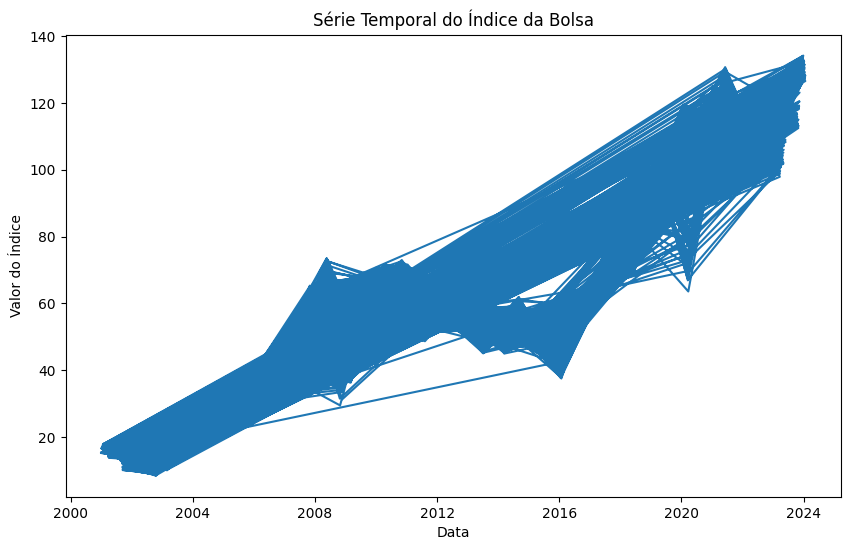

In [19]:
# Plotando a série temporal

plt.rcParams['figure.figsize'] = (10, 6)
plt.plot(df['ds'], df['y'])
plt.title('Série Temporal do Índice da Bolsa')
plt.xlabel('Data')
plt.ylabel('Valor do Índice')
plt.show()


In [25]:
df_indice = df.set_index('ds')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5714 entries, 2023-10-31 to 2001-02-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       5714 non-null   float64
dtypes: float64(1)
memory usage: 89.3 KB


In [32]:
df_indice = df_indice.asfreq('D').fillna(method='ffill')

C:\Users\Sergio Velloso\AppData\Local\Temp\ipykernel_2436\3801326432.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_indice = df_indice.asfreq('D').fillna(method='ffill')


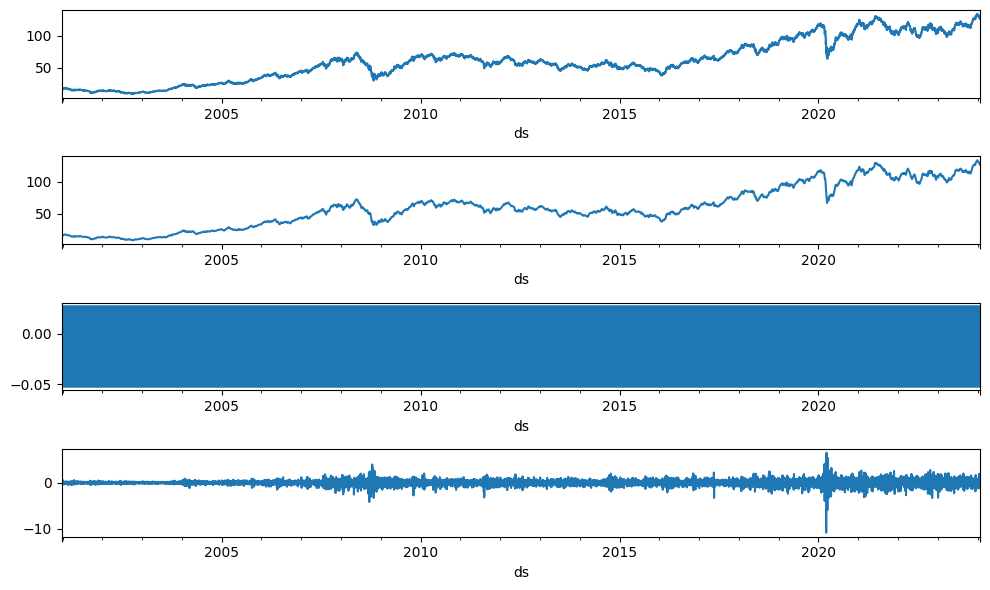

In [37]:
# Decompondo a série Temporal

resultados = seasonal_decompose(df_indice)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,6))

resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)


plt.tight_layout()

In [43]:
# Verificando se existe estacionaridade

X = df.y.values
result = adfuller(X)

print('Teste ADF')
print(f'Teste Estatístico: {result[0]}')
print(f'P-Value: {result[1]}')
print('Valores críticos:')

for key, value in result[4].items():
    print(f'\t{key}: {value}')

Teste ADF
Teste Estatístico: -17.05449754581241
P-Value: 8.02671903745614e-30
Valores críticos:
	1%: -3.4315018059408064
	5%: -2.862048987088664
	10%: -2.5670409321377208


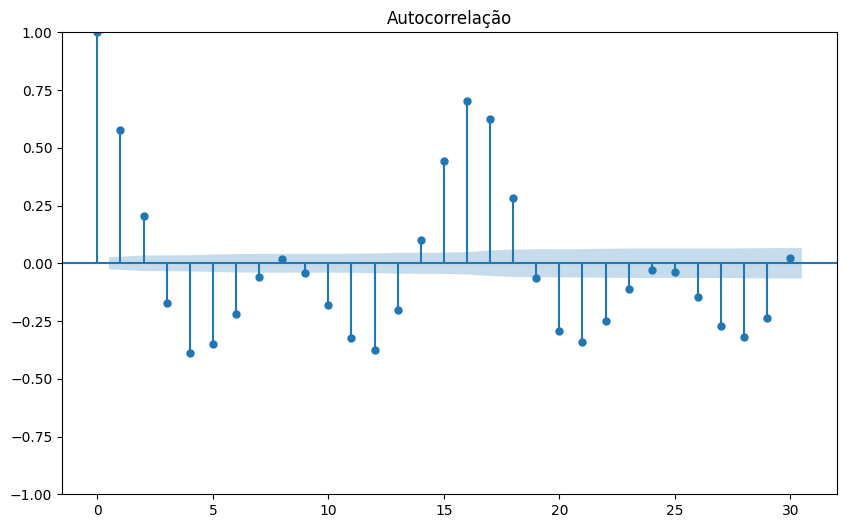

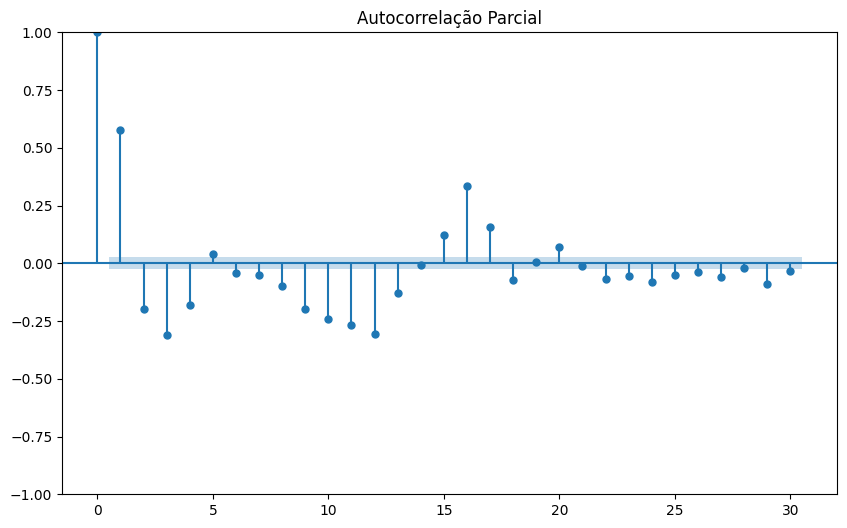

In [45]:
# Análise da Autocorrelação

plot_acf(df['y'], lags=30)
plt.title('Autocorrelação')
plt.show()

plot_pacf(df['y'], lags=30)
plt.title('Autocorrelação Parcial')
plt.show()

### Separação dos dados de treino e teste

In [48]:
treino = df.loc[df['ds'] < '2023-12-08']
valid = df.loc[df['ds'] >= '2023-12-08']
h = valid['ds'].nunique()
h


30

### Configuração do modelo

In [49]:
m = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)

In [50]:
m.fit(treino)

23:55:02 - cmdstanpy - INFO - Chain [1] start processing
23:55:03 - cmdstanpy - INFO - Chain [1] done processing


In [56]:
future = m.make_future_dataframe(periods=len(valid))

In [57]:
forecast = m.predict(future)

In [65]:
y_true = valid['y'].values
y_pred = forecast[-30:]['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(mean_squared_error(y_true, y_pred))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 13.146786509938385
RMSE: 13.339524524643908


In [58]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)